In [1]:
!nvidia-smi

Tue Aug 10 09:31:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# exp

In [2]:
# Dataset
!gdown --id 12dG-TqDZz-BLEdlJydVfPSmhdIksjk5y
!gdown --id 1QEtkeZOsNNy1WJeB1i3kIiGfpbzDWhVS

Downloading...
From: https://drive.google.com/uc?id=12dG-TqDZz-BLEdlJydVfPSmhdIksjk5y
To: /content/exp_demo_D_500000.pth
2.16MB [00:00, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QEtkeZOsNNy1WJeB1i3kIiGfpbzDWhVS
To: /content/train_data.npy
288MB [00:02, 120MB/s] 


In [3]:
# HouseGAN
!git clone https://github.com/ennauata/housegan.git

# Tejas attention houseGAN

# !git clone https://github.com/tejasbana/housegan.git

Cloning into 'housegan'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 145 (delta 12), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (145/145), 160.06 KiB | 7.62 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [4]:
%cd housegan/

/content/housegan


In [ ]:
# Install requirements
!pip install -r requirements.txt

In [ ]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz

In [7]:
# remove edges from nx.draw in variation_bbs_with_target_graph_segments_suppl draw graph line 72
!pip install webcolors
!pip install svgwrite

  Using cached webcolors-1.11.1-py3-none-any.whl (9.9 kB)
     |████████████████████████████████| 66 kB 3.6 MB/s 


In [8]:
!mkdir checkpoints
!mv ../exp_with_graph_global_new_D_200000.pth ./checkpoints
!mv ../train_data.npy ./checkpoints

mv: cannot stat '../exp_with_graph_global_new_D_200000.pth': No such file or directory


In [9]:
## Testing
# !python variation_bbs_with_target_graph_segments_suppl.py --num_variations=4 --batch_size=1

In [ ]:
import torch
b = []
for i in range(200):
    a = torch.tensor(i/23)
    b.append(a)
torch.stack(b).mean()

In [ ]:
# Training
!gdown --id 1vU0KCE_qh-ynhBBOdpF1VGE7tFsMmi39

In [ ]:
!python main.py --n_epochs 10 --sample_interval 5 --batch_size 16 --target_set D --exp_folder exp_example.

16
107315
target samples: defaultdict(<class 'int'>, {3: 4126, 7: 18971, 13: 5454, 9: 16395, 6: 16179, 17: 241, 1: 2138, 8: 17591, 4: 7005, 5: 11547, 2: 2667, 14: 2875, 18: 122, 15: 1248, 16: 531, 20: 47, 24: 19, 19: 82, 23: 13, 22: 25, 21: 20, 34: 1, 32: 2, 26: 4, 25: 5, 30: 1, 29: 1, 31: 1, 27: 2, 35: 1, 28: 1})
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
5000
target samples: defaultdict(<class 'int'>, {11: 1787, 12: 1260, 10: 1953})
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are a

In [10]:
%cd housegan/

[Errno 2] No such file or directory: 'housegan/'
/content/housegan


In [ ]:
!rm -fr .git

In [ ]:
!zip -r housegan.zip /content/housegan

## Custom Inputs

In [11]:
import argparse
import os
import numpy as np
import math
import sys
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image

from floorplan_dataset_maps import FloorplanGraphDataset, floorplan_collate_fn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from PIL import Image, ImageDraw
from reconstruct import reconstructFloorplan
import svgwrite
from utils import bb_to_img, bb_to_vec, bb_to_seg, mask_to_bb, remove_junctions, ID_COLOR, bb_to_im_fid
from models import Generator
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

In [12]:
def one_hot_encoding(nodes):
    length = 10
    ans = []
    for k in nodes:
        temp = [0 if i != ulta[k] else 1 for i in range(1, length+1)]
        ans.append(temp)
    return torch.Tensor(ans)
def process_edges(nodes, edges):
    prep_edgs = []
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if j > i:
                if [i, j] in edges or [j, i] in edges:
                    prep_edgs.append([i, 1, j])
                else:
                    prep_edgs.append([i, -1, j])
    return torch.tensor(prep_edgs, dtype=torch.int32)

In [13]:
conversion = {1: 'living', 2: 'kitchen', 3: 'bedroom', 
              4: 'bathroom', 5:'closet', 6:'balcony', 7: 'corridor', 
              8: 'dining', 9: 'laundry', 10: 'unkown'}
ulta = {conversion[i]:i for i in conversion.keys()}
ulta

{'balcony': 6,
 'bathroom': 4,
 'bedroom': 3,
 'closet': 5,
 'corridor': 7,
 'dining': 8,
 'kitchen': 2,
 'laundry': 9,
 'living': 1,
 'unkown': 10}

In [14]:
nodes = ['living',
         'bedroom',
         'bedroom',
         'bathroom',
         'bathroom',
         'balcony',
         'unkown',
         'dining'
]
edges = [
         [0],
         [0, 1],
         [0, 2],
         [0, 6],
         [0, 7],
         [1],
         [1, 0],
         [1, 3],
         [1, 5],
         [1,6],
         [2],
         [2, 0],
         [2, 4],
         [3],
         [3, 1],
         [4],
         [4, 2],
         [5],
         [5, 1],
         [6],
         [6, 0],
         [7],
         [7, 0],
          [7]
        #  [2, 3],
        #  [3, 2],
        #  [3, 1],
]
n, e = one_hot_encoding(nodes), process_edges(nodes, edges)

def custom_input(n, e):
    return n, e

In [15]:
n.shape

torch.Size([8, 10])

In [16]:
def floorplan_collate_fn(nds,eds):
	all_rooms_mks, all_nodes, all_edges = [], [], []
	all_node_to_sample, all_edge_to_sample = [], []
	node_offset = 0
	for i, (nodes, edges) in enumerate(zip(nds,eds)):
		O, T = nodes.size(0), edges.size(0)
		# all_rooms_mks.append(rooms_mks)
		all_nodes.append(nodes)
		edges = edges.clone()
		if edges.shape[0] > 0:
			# edges[:, 0] += node_offset
			# edges[:, 2] += node_offset
			all_edges.append(edges)
		all_node_to_sample.append(torch.LongTensor(O).fill_(i))
		all_edge_to_sample.append(torch.LongTensor(T).fill_(i))
		node_offset += O
	# all_rooms_mks = torch.cat(all_rooms_mks, 0)
	all_nodes = torch.cat(all_nodes)
	if len(all_edges) > 0:
		all_edges = torch.cat(all_edges)
	else:
		all_edges = torch.tensor([])       
	all_node_to_sample = torch.cat(all_node_to_sample)
	all_edge_to_sample = torch.cat(all_edge_to_sample)
	return all_nodes, all_edges, all_node_to_sample, all_edge_to_sample

Namespace(batch_size=1, channels=1, exp_folder='exp', latent_dim=128, n_cpu=16, num_variations=4)
5000
target samples: defaultdict(<class 'int'>, {11: 1787, 12: 1260, 10: 1953})


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: b is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


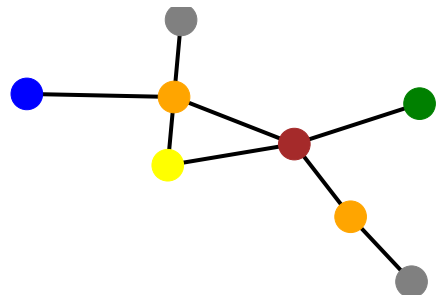

In [17]:

parser = argparse.ArgumentParser()
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=128, help="dimensionality of the latent space")
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--num_variations", type=int, default=4, help="number of variations")
parser.add_argument("--exp_folder", type=str, default='exp', help="destination folder")

opt = parser.parse_args("")
print(opt)

numb_iters = 200000
exp_name = 'exp_with_graph_global_new'
target_set = 'D'
phase='eval'
checkpoint = './checkpoints/{}_{}_{}.pth'.format(exp_name, target_set, numb_iters)
os.makedirs("./dump/", exist_ok=True)
os.makedirs("./output/", exist_ok=True)

def pad_im(cr_im, final_size=256, bkg_color='white'):    
    new_size = int(np.max([np.max(list(cr_im.size)), final_size]))
    padded_im = Image.new('RGB', (new_size, new_size), 'white')
    padded_im.paste(cr_im, ((new_size-cr_im.size[0])//2, (new_size-cr_im.size[1])//2))
    padded_im = padded_im.resize((final_size, final_size), Image.ANTIALIAS)
    return padded_im

def draw_graph(g_true):
    # build true graph 
    G_true = nx.Graph()
    colors_H = []
    for k, label in enumerate(g_true[0]):
        _type = label+1 
        if _type >= 0:
            G_true.add_nodes_from([(k, {'label':_type})])
            colors_H.append(ID_COLOR[_type])
    for k, m, l in g_true[1]:
        if m > 0:
            G_true.add_edges_from([(k, l)], color='b',weight=4)    
    plt.figure()
    pos = nx.nx_agraph.graphviz_layout(G_true, prog='neato')

    edges = G_true.edges()
    colors = ['black' for u,v in edges]
    weights = [4 for u,v in edges]

    nx.draw(G_true, pos, node_size=1000, node_color=colors_H, font_size=0, font_weight='bold', edge_color=colors, width=weights)
    plt.tight_layout()
    plt.savefig('./dump/_true_graph.jpg', format="jpg")
    rgb_im = Image.open('./dump/_true_graph.jpg')
    rgb_arr = pad_im(rgb_im).convert('RGBA')
    return rgb_arr

        
import cv2
import webcolors
def draw_masks(masks, real_nodes):

#     transp = Image.new('RGBA', img.size, (0,0,0,0))  # Temp drawing image.
#     draw = ImageDraw.Draw(transp, "RGBA")
#     draw.ellipse(xy, **kwargs)
#     # Alpha composite two images together and replace first with result.
#     img.paste(Image.alpha_composite(img, transp))
    
    bg_img = Image.new("RGBA", (256, 256), (255, 255, 255, 0))  # Semitransparent background.
    for m, nd in zip(masks, real_nodes):
        
        # draw region
        reg = Image.new('RGBA', (32, 32), (0,0,0,0))
        dr_reg = ImageDraw.Draw(reg)
        m[m>0] = 255
        m[m<0] = 0
        m = m.detach().cpu().numpy()
        m = Image.fromarray(m)
        color = ID_COLOR[nd+1]
        r, g, b = webcolors.name_to_rgb(color)
        dr_reg.bitmap((0, 0), m.convert('L'), fill=(r, g, b, 32))
        reg = reg.resize((256, 256))
        
        bg_img.paste(Image.alpha_composite(bg_img, reg))

  
    for m, nd in zip(masks, real_nodes):
        cnt = Image.new('RGBA', (256, 256), (0,0,0,0))
        dr_cnt = ImageDraw.Draw(cnt)
        
        mask = np.zeros((256,256,3)).astype('uint8')
        m[m>0] = 255
        m[m<0] = 0
        m = m.detach().cpu().numpy()[:, :, np.newaxis].astype('uint8')
        m = cv2.resize(m, (256, 256), interpolation = cv2.INTER_AREA) 
        ret,thresh = cv2.threshold(m,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:  
            contours = [c for c in contours]
        color = ID_COLOR[nd+1]
        r, g, b = webcolors.name_to_rgb(color)
        cv2.drawContours(mask, contours, -1, (255, 255, 255), 2)
        
        mask = Image.fromarray(mask)
        dr_cnt.bitmap((0, 0), mask.convert('L'), fill=(r, g, b, 256))
        
        bg_img.paste(Image.alpha_composite(bg_img, cnt))
    
#     im2 = np.zeros((256,256,3)).astype('uint8') + 255
#     for m, nd in zip(masks, real_nodes):
#         m[m>0] = 255
#         m[m<0] = 0
#         m = m.detach().cpu().numpy()[:, :, np.newaxis].astype('uint8')
#         m = cv2.resize(m, (256, 256), interpolation = cv2.INTER_AREA) 
#         ret,thresh = cv2.threshold(m,127,255,0)
#         contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#         if len(contours) > 0:  
#             contours = [c for c in contours]
#         color = ID_COLOR[nd+1]
#         r, g, b = webcolors.name_to_rgb(color)

#         cv2.drawContours(im2, contours, -1, (r, g, b), 2)
#     im2 = Image.fromarray(im2).convert('RGBA')

#     im.paste(im2)
#     out.save('./test.png')
#     im.save('./test_reg.png')

    return bg_img

def draw_floorplan(dwg, junctions, juncs_on, lines_on):

    # draw edges
    for k, l in lines_on:
        x1, y1 = np.array(junctions[k])
        x2, y2 = np.array(junctions[l])
        #fill='rgb({},{},{})'.format(*(np.random.rand(3)*255).astype('int'))
        dwg.add(dwg.line((float(x1), float(y1)), (float(x2), float(y2)), stroke='black', stroke_width=4, opacity=1.0))

    # draw corners
    for j in juncs_on:
        x, y = np.array(junctions[j])
        dwg.add(dwg.circle(center=(float(x), float(y)), r=3, stroke='red', fill='white', stroke_width=2, opacity=1.0))
    return 

# Create folder
os.makedirs(opt.exp_folder, exist_ok=True)

# Initialize generator and discriminator
generator = Generator()
generator.load_state_dict(torch.load(checkpoint))

# Initialize variables
cuda = True if torch.cuda.is_available() else False
# cuda = False 
if cuda:
    generator.cuda()
rooms_path = '/content/housegan/checkpoints/'

# Initialize dataset iterator
fp_dataset_test = FloorplanGraphDataset(rooms_path, transforms.Normalize(mean=[0.5], std=[0.5]), target_set=target_set, split=phase)
fp_loader = torch.utils.data.DataLoader(fp_dataset_test, 
                                        batch_size=opt.batch_size, 
                                        shuffle=False, collate_fn=floorplan_collate_fn)
# Optimizers
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ------------
#  Vectorize
# ------------
globalIndex = 0
final_images = []
target_graph = list(range(500))
page_count = 0
n_rows = 0
# for i, batch in enumerate(fp_loader):
    # if i not in target_graph:
        # continue
        
    # Unpack batch
    # mks, nds, eds, nd_to_sample, ed_to_sample = batch
# print("real",nds, eds)
nds, eds = custom_input(n, e)
# print("custom",nds, eds)

#custom
# batch = (n,e)
# nds, eds, nd_to_sample, ed_to_sample = floorplan_collate_fn(batch)


# Configure input
# real_mks = Variable(mks.type(Tensor))
given_nds = Variable(nds.type(Tensor))
# print("real_mks:",real_mks.shape[0])
# print("given_nds:",given_nds.shape[0])
# break
given_eds = eds
for k in range(opt.num_variations):
#         print('var num {}'.format(k))
    # plot images
    z = Variable(Tensor(np.random.normal(0, 1, (given_nds.shape[0], opt.latent_dim))))
    with torch.no_grad():
        gen_mks = generator(z, given_nds, given_eds)
        gen_bbs = np.array([np.array(mask_to_bb(mk)) for mk in gen_mks.detach().cpu()])
        # real_bbs = np.array([np.array(mask_to_bb(mk)) for mk in real_mks.detach().cpu()])
        real_nodes = np.where(given_nds.detach().cpu()==1)[-1]
    gen_bbs = gen_bbs[np.newaxis, :, :]/32.0
    junctions = np.array(bb_to_vec(gen_bbs))[0, :, :]
    regions = np.array(bb_to_seg(gen_bbs))[0, :, :, :].transpose((1, 2, 0))
    graph = [real_nodes, None]
    
    if k == 0:
        graph_arr = draw_graph([real_nodes, eds.detach().cpu().numpy()])
        final_images.append(graph_arr)
        
#             # place real 
#             real_bbs = real_bbs[np.newaxis, :, :]/32.0
#             real_im = bb_to_im_fid(real_bbs, real_nodes)
#             final_images.append(real_im)
        
        
    # reconstruct
    fake_im_seg = draw_masks(gen_mks, real_nodes)
    final_images.append(fake_im_seg)
    fake_im_bb = bb_to_im_fid(gen_bbs, real_nodes, im_size=256).convert('RGBA')
    final_images.append(fake_im_bb)
n_rows += 1
# if (n_rows+1)%12 == 0: 
final_images_new = []
for im in final_images:
    print(np.array(im).shape)
    final_images_new.append(torch.tensor(np.array(im).transpose((2, 0, 1)))/255.0)

# print('final: ', final_images_new[0].shape)
final_images = final_images_new
final_images = torch.stack(final_images)
# print(final_images)
save_image(final_images, "./output/results_page_{}_{}.png".format(target_set, page_count), nrow=2*opt.num_variations+1, padding=2, range=(0, 1), pad_value=0.5, normalize=False)
page_count += 1
n_rows = 0
final_images = []

# break


# validate

In [ ]:
# Dataset
!gdown --id 12dG-TqDZz-BLEdlJydVfPSmhdIksjk5y
!gdown --id 1QEtkeZOsNNy1WJeB1i3kIiGfpbzDWhVS

In [ ]:
# HouseGAN
!git clone https://github.com/ennauata/housegan.git

In [ ]:
%cd housegan/

In [ ]:
# Install requirements
!pip install -r requirements.txt

In [ ]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz

In [ ]:
# remove edges from nx.draw in variation_bbs_with_target_graph_segments_suppl draw graph line 72
!pip install webcolors
!pip install svgwrite

In [ ]:
!mkdir checkpoints
!mv ../exp_with_graph_global_new_D_200000.pth ./checkpoints
# !mv ./train_data.npy ./checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
# Testing
!python variation_bbs_with_target_graph_segments_suppl.py --num_variations=4 --batch_size=1

Streaming output truncated to the last 5000 lines.

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]), tensor([[ 0,  1,  1],
        [ 0, -1,  2],
   

# NPY file explor

In [ ]:
import numpy as np
rooms_path = './train_data.npy'
subgraphs = np.load('../train_data.npy', allow_pickle=True)

In [ ]:
for g in subgraphs:
    input = np.array(g)
    print(g)
    break

[[6.0, 2.0, 4.0], [array([132,   6, 148,  65]), array([110,  68, 208, 130]), array([132,  91, 160, 130])], [[108, 89, 130, 89, 8, 0], [108, 66, 130, 66, 0, 8], [108, 66, 108, 89, 8, 0], [209, 66, 209, 131, 0, 8], [130, 4, 149, 4, 0, 6], [130, 89, 161, 89, 8, 4], [130, 4, 130, 66, 6, 0], [149, 4, 149, 66, 0, 6], [130, 89, 130, 131, 4, 0], [161, 89, 161, 131, 2, 4], [130, 66, 149, 66, 6, 8], [149, 66, 209, 66, 0, 8], [130, 131, 161, 131, 4, 0], [161, 131, 209, 131, 8, 0]], [[1], [1], [1], [1], [0], [1, 2], [0], [0], [2], [1, 2], [0, 1], [1], [2], [1]], [6, 7, 9, 2, 3], 'floorplan_high_res/0d/00/464243c9d2ffd5507b24bdced40a/0001.jpg']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
input[-1]

'floorplan_high_res/0d/00/464243c9d2ffd5507b24bdced40a/0001.jpg'

In [ ]:
for values in input:
    print(values)

[6.0, 2.0, 4.0]
[array([132,   6, 148,  65]), array([110,  68, 208, 130]), array([132,  91, 160, 130])]
[[108, 89, 130, 89, 8, 0], [108, 66, 130, 66, 0, 8], [108, 66, 108, 89, 8, 0], [209, 66, 209, 131, 0, 8], [130, 4, 149, 4, 0, 6], [130, 89, 161, 89, 8, 4], [130, 4, 130, 66, 6, 0], [149, 4, 149, 66, 0, 6], [130, 89, 130, 131, 4, 0], [161, 89, 161, 131, 2, 4], [130, 66, 149, 66, 6, 8], [149, 66, 209, 66, 0, 8], [130, 131, 161, 131, 4, 0], [161, 131, 209, 131, 8, 0]]
[[1], [1], [1], [1], [0], [1, 2], [0], [0], [2], [1, 2], [0, 1], [1], [2], [1]]
[6, 7, 9, 2, 3]
floorplan_high_res/0d/00/464243c9d2ffd5507b24bdced40a/0001.jpg


In [ ]:
def filter_graphs(graphs, min_h=0.03, min_w=0.03):
    new_graphs = []
    for g in graphs:
        
        # retrieve data
        rooms_type = g[0]
        rooms_bbs = g[1]
        
        # discard broken samples
        check_none = np.sum([bb is None for bb in rooms_bbs])
        check_node = np.sum([nd == 0 for nd in rooms_type])
        if (len(rooms_type) == 0) or (check_none > 0) or (check_node > 0):
            continue
        
        # filter small rooms
        tps_filtered = []
        bbs_filtered = []
        for n, bb in zip(rooms_type, rooms_bbs):
            h, w = (bb[2]-bb[0]), (bb[3]-bb[1])
            if h > min_h and w > min_w:
                tps_filtered.append(n)
                bbs_filtered.append(bb)
        
        # update graph
        g_new = [tps_filtered, bbs_filtered]
        new_graphs.append(g_new)
    return new_graphs

In [ ]:
subgraphs = filter_graphs(subgraphs)

In [ ]:
np.array(subgraphs).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(145322, 2)

In [ ]:
subgraphs[:2]

[[[6.0, 2.0, 4.0],
  [array([132,   6, 148,  65]),
   array([110,  68, 208, 130]),
   array([132,  91, 160, 130])]],
 [[2.0, 4.0, 6.0, 6.0, 3.0, 3.0, 7.0],
  [array([  4,  30, 113, 112]),
   array([116,  30, 168,  83]),
   array([  4,  86,  57, 112]),
   array([116,  86, 168, 112]),
   array([  4, 115,  84, 224]),
   array([ 87, 115, 168, 224]),
   array([  4, 227, 168, 250])]]]

In [ ]:
for g in subgraphs:
        rooms_type = g[0] 
        # mks, nds, eds, nd_to_sample, ed_to_sample = g 
        print(mks, nds, eds, nd_to_sample, ed_to_sample)
        break